In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [30]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [31]:
df_offers = pd.read_excel("/content/drive/My Drive/WineKMC.xlsx",sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [32]:
df_offers.shape

(32, 7)

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [33]:
df_transactions = pd.read_excel("/content/drive/My Drive/WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [34]:
df_transactions.shape

(324, 3)

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. This is done below by merging the two datasets. 

In [35]:
#Perform merge function to combine the two dataframes
df_merged = df_offers.merge(df_transactions,on='offer_id',how='outer')
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [36]:
#Checking to see if there are any missing values
df_merged.isnull().sum()

offer_id         0
campaign         0
varietal         0
min_qty          0
discount         0
origin           0
past_peak        0
customer_name    0
n                0
dtype: int64

Next we transform the dataset into a 2D sparse matrix for clustering. This is done by first grouping the data by the *customer name* and *offer_id* based on the frequency of each combination. Then the dataset is unstacked to create a 2D representation. 

In [37]:
df_groupby = df_merged[['customer_name','offer_id','varietal']].groupby(['customer_name','offer_id']).count().unstack().fillna(0)
df_groupby.head()

varietal                           ...                              
offer_id            1    2    3    4    5    6   ...   27   28   29   30   31   32
customer_name                                    ...                              
Adams              0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  1.0  0.0  0.0
Allen              0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0
Anderson           0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
Bailey             0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0
Baker              0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0

[5 rows x 32 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

SS needs to be small for better clusterings as that would indicate that the distance between the points and the cluster centroid is small. Hence the points would be packed together in a cluster more closely distinguishing one cluster from another. 

In [38]:
import numpy as np

x_cols = df_groupby
x_cols = np.array(x_cols['varietal'])

x_cols.shape

(100, 32)

In [39]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=5, random_state=0).fit(x_cols)
print (kmeans.labels_)
print (kmeans.cluster_centers_)
print (kmeans.inertia_)

[1 0 4 1 2 2 4 1 2 1 2 4 1 2 0 4 0 4 1 0 1 1 2 2 4 3 3 0 0 0 1 1 0 2 1 1 0
 1 3 1 4 4 1 2 1 2 1 1 0 0 0 3 4 4 2 1 4 0 1 2 2 1 0 1 1 4 4 0 2 0 3 0 2 1
 2 1 4 2 1 4 3 0 3 4 1 1 1 3 0 1 2 1 0 1 3 2 1 3 2 3]
[[ 5.00000000e-02  5.00000000e-02 -3.46944695e-17  1.50000000e-01
   1.00000000e-01  5.00000000e-02  5.00000000e-02 -2.77555756e-17
   3.50000000e-01 -2.77555756e-17  4.00000000e-01  2.50000000e-01
  -3.46944695e-17 -2.77555756e-17  5.00000000e-02  2.50000000e-01
  -2.77555756e-17 -5.55111512e-17 -6.93889390e-18  2.00000000e-01
  -6.93889390e-18  1.50000000e-01  5.00000000e-02 -6.93889390e-17
   2.50000000e-01  1.00000000e-01  1.00000000e-01  1.00000000e-01
   5.00000000e-02  1.00000000e-01  1.00000000e-01  1.00000000e-01]
 [-4.16333634e-17 -4.16333634e-17  3.03030303e-02 -8.32667268e-17
  -1.38777878e-17  3.03030303e-02  4.24242424e-01  4.84848485e-01
  -4.16333634e-17  6.06060606e-02  8.32667268e-17 -2.08166817e-17
   1.81818182e-01  1.38777878e-17 -4.16333634e-17 -2.08166817e-17
  -

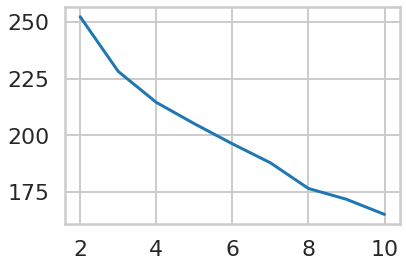

In [40]:
SS = []
K = range(2,11)

for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_cols)
    SS.append(kmeans.inertia_)

plt.plot(K,SS)

From the plot, the elbow point appears to be at K=3, as the slope flattens out a little after that despite the downward trajectory. 

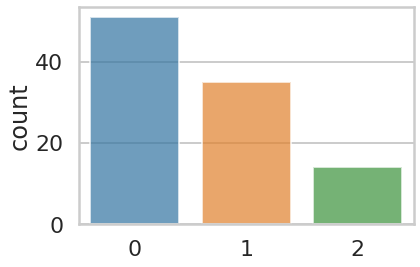

In [41]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(x_cols)
labels = kmeans.labels_
sns.countplot(labels,alpha=0.7)

In the elbow method, it was not completely obvious from the SS vs K plot where exactly the descent becomes slower. I used my best judgement. Not sure if it's the case all the time. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193


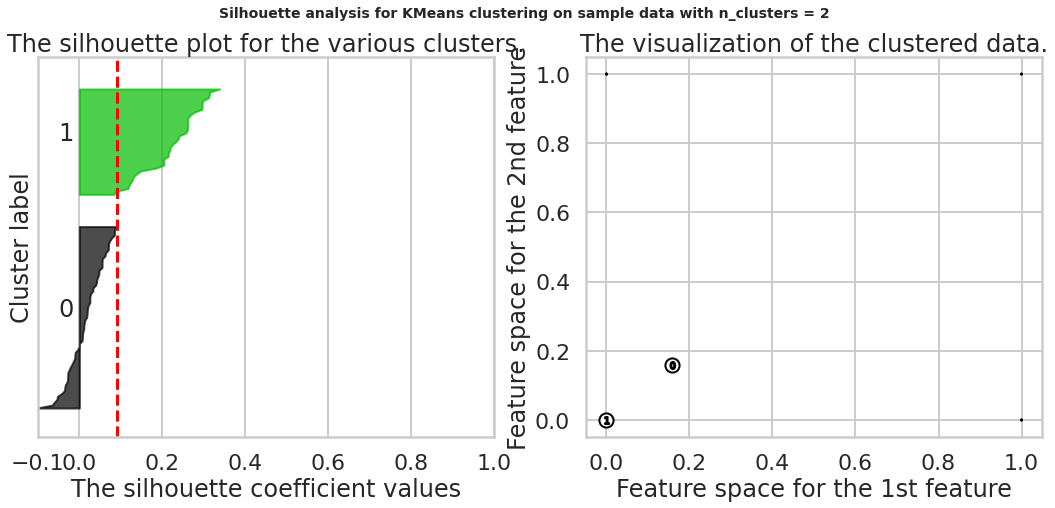

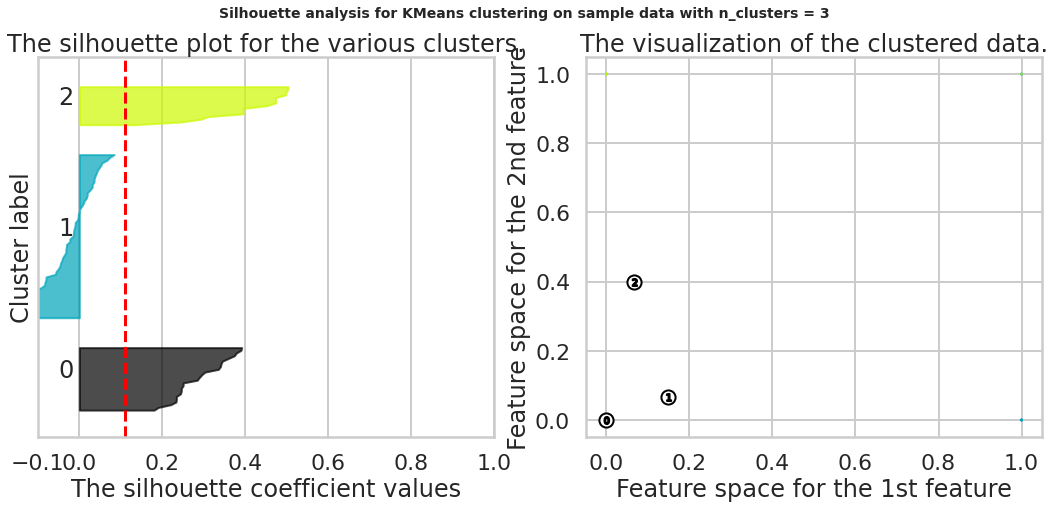

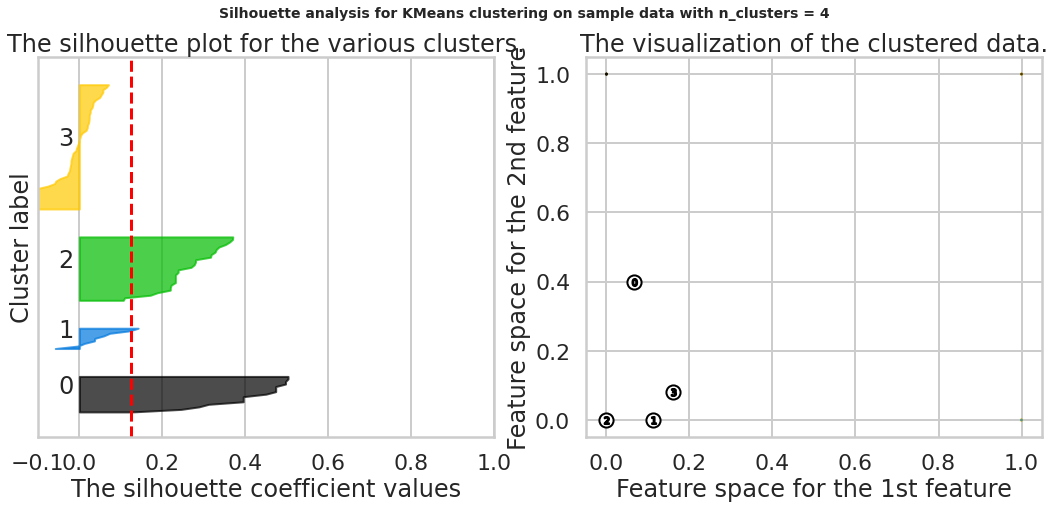

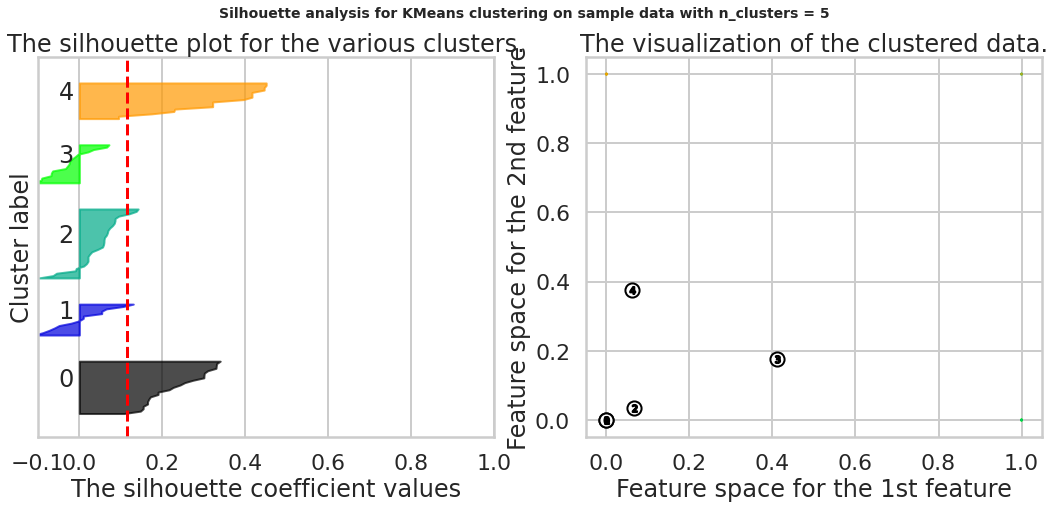

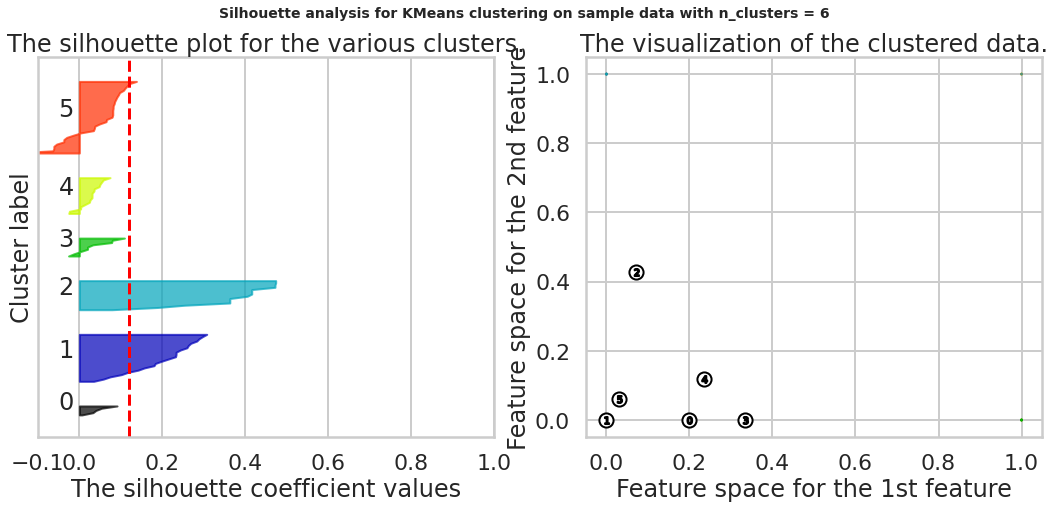

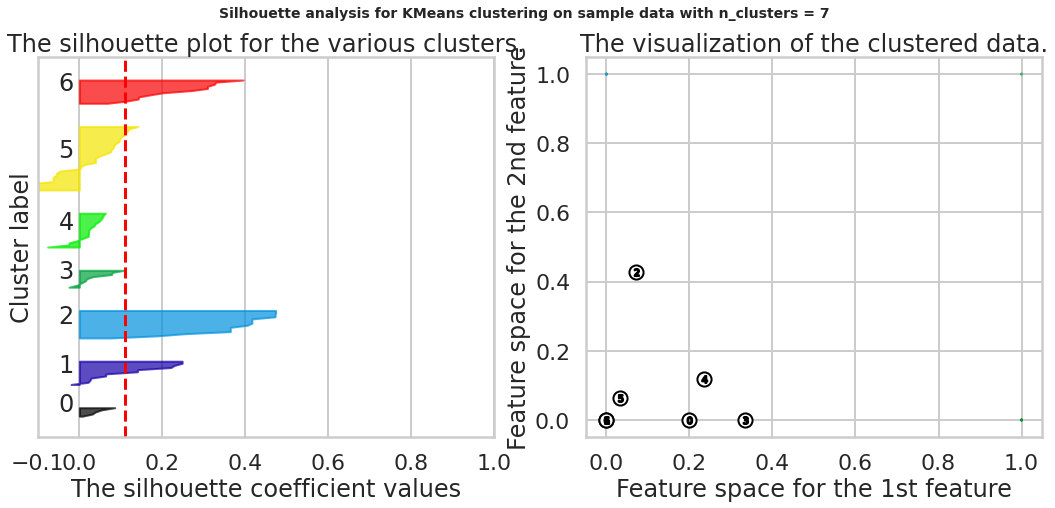

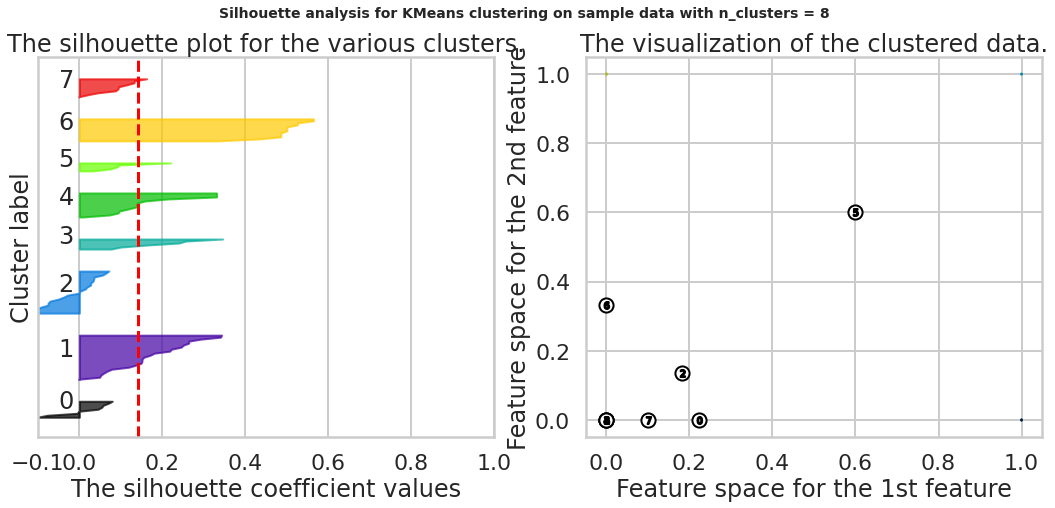

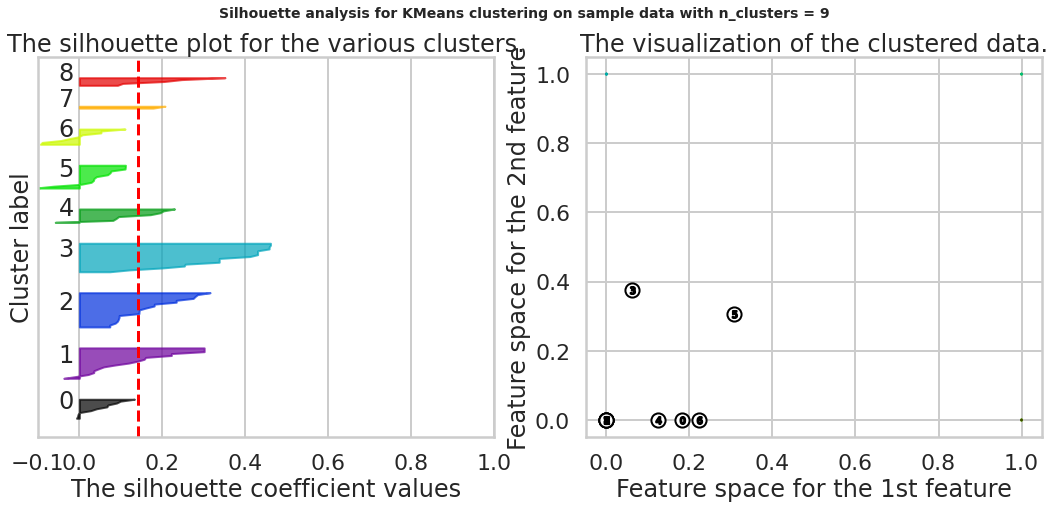

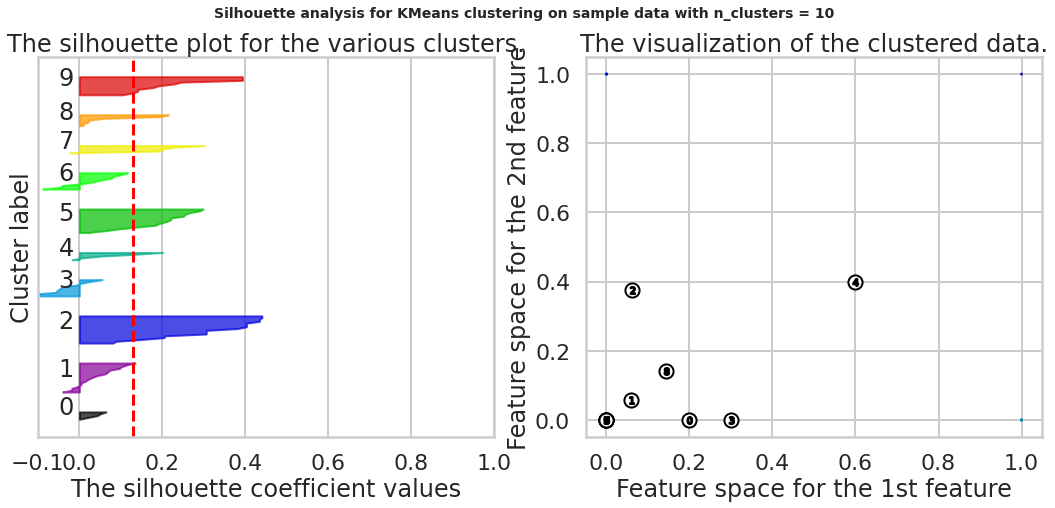

In [42]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    

plt.show()

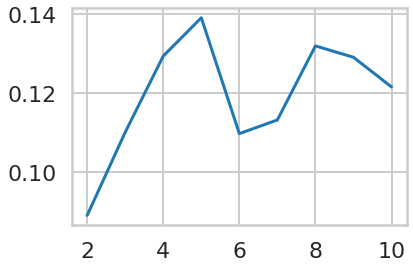

In [43]:
SS = []
K = range(2,11)
silhouette = []

for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(x_cols)
    silhouette.append(sklearn.metrics.silhouette_score(x_cols,kmeans.labels_))

plt.plot(K,silhouette)



From the silhouette vs K plot above, the best score appears to be ~0.14 for 7 clusters. This is different from the elbow method where the the optimum K was 3. 

In [44]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(x_cols)
labels = kmeans.labels_
print (labels)

[4 5 2 4 0 0 2 1 3 4 3 2 4 3 3 2 6 2 4 3 4 1 3 3 2 3 1 6 5 2 4 1 3 0 4 1 3
 4 3 4 2 2 1 5 4 3 4 0 5 3 3 0 3 2 0 1 2 4 1 1 0 1 5 1 1 2 2 1 3 5 1 5 3 4
 5 4 2 0 1 2 6 6 5 2 1 1 4 6 5 1 5 4 1 4 3 3 1 0 5 5]


### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. 

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)
print (components)

[[ 1.00757996e+00  1.08214665e-01]
 [-2.87539237e-01  4.47145141e-02]
 [-3.92032043e-01  1.03839141e+00]
 [ 6.99477269e-01 -2.25422232e-02]
 [ 8.81832248e-02 -4.71695431e-01]
 [-4.85281909e-01 -7.25503292e-01]
 [-5.91940987e-01  1.50649994e+00]
 [ 6.61731534e-01  9.03075520e-02]
 [-1.18943267e-01 -5.77498507e-01]
 [ 1.07982739e+00 -7.48818111e-03]
 [-2.40431061e-01 -6.17026041e-01]
 [-5.22247106e-01  1.23140642e+00]
 [ 1.26076270e+00 -1.42550704e-02]
 [-5.79220584e-01 -4.20474690e-01]
 [ 1.93998464e-01  1.03057282e-02]
 [-3.92032043e-01  1.03839141e+00]
 [-4.06275667e-01 -4.57711391e-02]
 [-5.91940987e-01  1.50649994e+00]
 [ 7.36154519e-01  1.17752476e-01]
 [-3.49056937e-01 -2.67081210e-01]
 [ 1.41224694e+00 -1.23874426e-01]
 [ 1.81048277e-01 -2.06529405e-02]
 [-3.71484955e-01 -3.48006774e-01]
 [-5.09136903e-01 -6.87321373e-01]
 [-2.39706096e-01  9.11843998e-01]
 [-7.82355465e-01 -5.18475045e-01]
 [-2.99665902e-01  6.96444453e-03]
 [-4.12829546e-01 -1.21989471e-02]
 [-3.39145922e-01 -1

In [46]:
df_pca = pd.DataFrame()
df_pca['customer name'] = df_groupby.index
df_pca['label'] = labels
df_pca['x'] = components[:,0]
df_pca['y'] = components[:,1]
df_pca.head()

,customer name,label,x,y
0,Adams,4,1.007580,0.108215
1,Allen,5,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,4,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


### Scatter plot of clusters with *K=7*

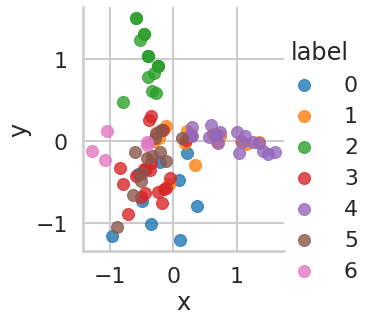

In [47]:
sns.lmplot(x='x',y='y',data=df_pca,hue='label',fit_reg=False)

### Scatter plot of clusters with *K=3*

In [48]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(x_cols)
labels = kmeans.labels_
pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)
df_pca = pd.DataFrame()
df_pca['customer name'] = df_groupby.index
df_pca['label'] = kmeans.labels_
df_pca['x'] = components[:,0]
df_pca['y'] = components[:,1]
df_pca.head()

,customer name,label,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


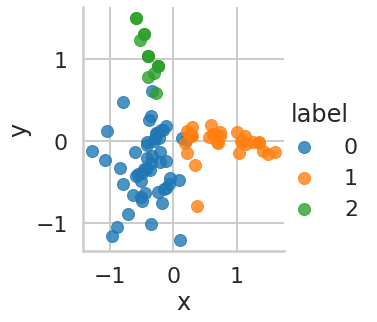

In [49]:
sns.lmplot(x='x',y='y',data=df_pca,hue='label',fit_reg=False)

Visually, the scatterplot with K=3 provides the best result despite not having the best silhouette score. For K=7, clusters 0 and 1 are distinct but the others tend to overlap making the distinction blurry. 

In [50]:
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [51]:
df_merged['varietal'].value_counts()

Champagne             81
Pinot Noir            44
Prosecco              43
Espumante             40
Malbec                32
Cabernet Sauvignon    32
Merlot                20
Pinot Grigio          17
Chardonnay            15
Name: varietal, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

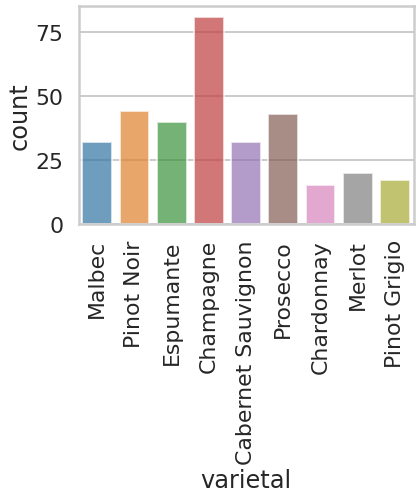

In [52]:
sns.countplot(x='varietal',data=df_merged,alpha=0.7)
plt.xticks(rotation=90)

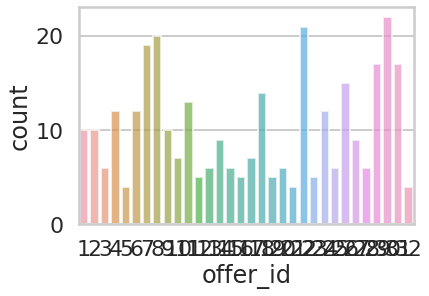

In [53]:
sns.countplot(x='offer_id',data=df_merged,alpha=0.7)

In [54]:
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


### Analyzing clusters

In order to differentiate between the clusters, we need to create a mapping between the customer names and the cluster labels

In [55]:
labels

array([1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 1, 1,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int32)

In [56]:
#Creating dict for mapping customer names to labels
cust_lab_map = dict(zip(df_groupby.index,labels))
cust_lab_map

{'Adams': 1,
 'Allen': 0,
 'Anderson': 2,
 'Bailey': 1,
 'Baker': 0,
 'Barnes': 0,
 'Bell': 2,
 'Bennett': 1,
 'Brooks': 0,
 'Brown': 1,
 'Butler': 0,
 'Campbell': 2,
 'Carter': 1,
 'Clark': 0,
 'Collins': 0,
 'Cook': 2,
 'Cooper': 0,
 'Cox': 2,
 'Cruz': 1,
 'Davis': 0,
 'Diaz': 1,
 'Edwards': 1,
 'Evans': 0,
 'Fisher': 0,
 'Flores': 2,
 'Foster': 0,
 'Garcia': 0,
 'Gomez': 0,
 'Gonzalez': 0,
 'Gray': 0,
 'Green': 1,
 'Gutierrez': 1,
 'Hall': 0,
 'Harris': 0,
 'Hernandez': 1,
 'Hill': 1,
 'Howard': 0,
 'Hughes': 1,
 'Jackson': 0,
 'James': 1,
 'Jenkins': 2,
 'Johnson': 2,
 'Jones': 1,
 'Kelly': 0,
 'King': 1,
 'Lee': 0,
 'Lewis': 1,
 'Long': 1,
 'Lopez': 0,
 'Martin': 0,
 'Martinez': 0,
 'Miller': 0,
 'Mitchell': 0,
 'Moore': 2,
 'Morales': 0,
 'Morgan': 1,
 'Morris': 2,
 'Murphy': 1,
 'Myers': 1,
 'Nelson': 0,
 'Nguyen': 0,
 'Ortiz': 1,
 'Parker': 0,
 'Perez': 1,
 'Perry': 1,
 'Peterson': 0,
 'Phillips': 2,
 'Powell': 0,
 'Price': 0,
 'Ramirez': 0,
 'Reed': 0,
 'Reyes': 0,
 'Richardso

In [57]:
#Mapping customer names to cluster labels
df_merged['cluster'] = df_merged['customer_name'].map(cust_lab_map)
df_merged.head(10)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster
0,1,January,Malbec,72,56,France,False,Thomas,1,0
1,1,January,Malbec,72,56,France,False,Jackson,1,0
2,1,January,Malbec,72,56,France,False,Mitchell,1,0
3,1,January,Malbec,72,56,France,False,Peterson,1,0
4,1,January,Malbec,72,56,France,False,Wood,1,0
5,1,January,Malbec,72,56,France,False,Price,1,0
6,1,January,Malbec,72,56,France,False,Foster,1,0
7,1,January,Malbec,72,56,France,False,Sanders,1,0
8,1,January,Malbec,72,56,France,False,Butler,1,0
9,1,January,Malbec,72,56,France,False,Fisher,1,0


In [58]:
df_merged['cluster'].value_counts()

0    194
1     96
2     34
Name: cluster, dtype: int64

In [59]:
#Grouping by clusters and mean values
df_merged.groupby('cluster').mean()

,offer_id,min_qty,discount,past_peak,n
cluster,,,,,
0,16.231959,80.536082,63.613402,0.195876,1.0
1,17.562500,14.000000,54.989583,0.197917,1.0
2,19.911765,57.529412,48.588235,0.000000,1.0


Above, we have grouped the dataframe by each cluster to observe the differences in mean. The offer_id column does not provide much useful information since it's simply an identification feature. 

The *min_qty* column indicates that cluster 0 has the highest average value at 80.229 followed by cluster 1 at 65.581 whereas cluster 2 is significantly lower at 14.51. This tells us that on average, customers in cluster 0 tend to respond to offers where the min_qty is higher. That's one indication of customer behavior. 

Customers in cluster 0 also tend to respond to higher discounts on average whereas cluster 1 has the lowest discount value. Clusters 0 and 2 are similar when it comes to the past peak values, 0.207 and 0.193 respectively whereas cluster 1 shows a value of 0. Hence customers in cluster 1 always tend to respond to offers where the wines are never past their peak. For clusters 0 and 2, while the values are higher, they are still leaning more towards 0 than 1. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

Text(0, 0.5, 'Explained variance')

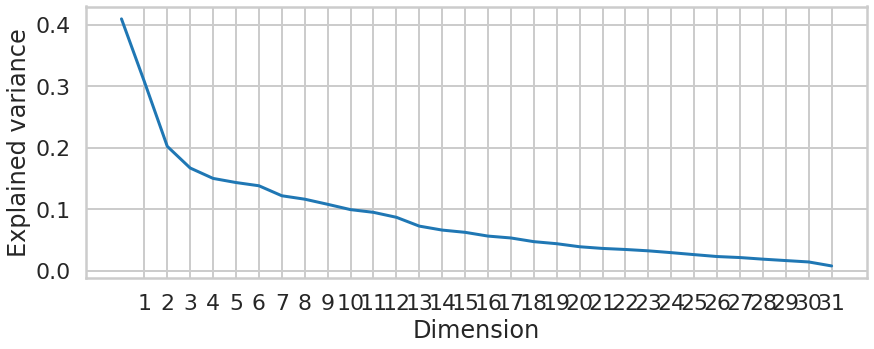

In [60]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(14,5))
plt.plot(pca.explained_variance_)
plt.xticks(range(1,32))
plt.xlabel("Dimension")
plt.ylabel("Explained variance")

Based on the figure, the optimal number of dimensions seems to be either 2 or 3 as the descent tends to slow down after that. Also, the explained variance keeps dropping further after that.  

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

# Trying out the other clustering techniques

In [61]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

In [62]:
#Affinity Propagation
for damping in np.arange(0.5,1,0.1):
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols)
    print("damping =", damping, "silhouette_score:", silhouette_score(x_cols, labels, random_state=0))

damping = 0.5 silhouette_score: 0.12346523604478911
damping = 0.6 silhouette_score: 0.12346523604478911
damping = 0.7 silhouette_score: 0.12346523604478911
damping = 0.7999999999999999 silhouette_score: 0.08954554999885996
damping = 0.8999999999999999 silhouette_score: 0.08954554999885996


In [63]:
#Spectral Clustering
for n_clusters in range(2,11):
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    print("Clusters =", n_clusters, "Silhouette_score is :", silhouette_score(x_cols, labels, random_state=0))

Clusters = 2 Silhouette_score is : 0.07631909829627558
Clusters = 3 Silhouette_score is : 0.10611539040197304
Clusters = 4 Silhouette_score is : 0.08627893400734331
Clusters = 5 Silhouette_score is : 0.09993402587297352
Clusters = 6 Silhouette_score is : 0.10504650829119899
Clusters = 7 Silhouette_score is : 0.08164787106585575
Clusters = 8 Silhouette_score is : 0.07972014232731978
Clusters = 9 Silhouette_score is : 0.07284676485348095
Clusters = 10 Silhouette_score is : 0.10080495638943343


In [64]:
#Agglomerative Clustering 
for n_clusters in range(2,11):
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    print("Clusters =", n_clusters, "Silhouette_score is :", silhouette_score(x_cols, labels, random_state=10))

Clusters = 2 Silhouette_score is : 0.08258017823184984
Clusters = 3 Silhouette_score is : 0.11625878863607858
Clusters = 4 Silhouette_score is : 0.128937578158815
Clusters = 5 Silhouette_score is : 0.14089739970831974
Clusters = 6 Silhouette_score is : 0.1471521720461323
Clusters = 7 Silhouette_score is : 0.15275152751051155
Clusters = 8 Silhouette_score is : 0.15578053718604024
Clusters = 9 Silhouette_score is : 0.12075124131971901
Clusters = 10 Silhouette_score is : 0.09754750747147792


In [65]:
#DBSCAN
for min_samples in range(1,4):
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    print("Min_samples =", min_samples, "Silhouette_score is :", silhouette_score(x_cols, labels, random_state=0))

Min_samples = 1 Silhouette_score is : 0.19
Min_samples = 2 Silhouette_score is : -0.021678059481408066
Min_samples = 3 Silhouette_score is : -0.10663555825496372


Agglomerative clustering yielded the best silhouette score out of all the algorithms, 0.1557. The best score with K-means was ~0.14. However, none of the techniques yielded a score close to 1. This indicates that the clustering is not distinct enough. 